# Question 1 - Extracting Tesla Stock Data Using yfinance


In [1]:
import pandas as pd
import numpy as np
import requests
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

tsla = yf.Ticker("TSLA")
tsla_hist = tsla.history(start="2010-01-01").reset_index()
tsla_hist.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


# Question 2 - Extracting Tesla Revenue Data Using Webscraping

In [6]:
import pandas as pd
import numpy as np
import requests
import yfinance as yf

def scrape_quarterly_revenue(url: str):
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
        "Referer": "https://www.google.com/"
    }
    try:
        r = requests.get(url, headers=headers, timeout=30)
        r.raise_for_status()
        tables = pd.read_html(r.text)
        def _is_quarterly(df):
            header = " ".join(map(str, df.columns))
            return "Quarterly" in header and "Revenue" in header
        target = None
        for df in tables:
            if _is_quarterly(df):
                target = df.copy()
                break
        if target is None:
            for df in tables:
                cols = [str(c).lower() for c in df.columns]
                if any("quarter" in c for c in cols) and any("revenue" in c for c in cols):
                    target = df.copy()
                    break
        if target is None:
            raise ValueError("Quarterly revenue table not found.")
        target.columns = [str(c).strip() for c in target.columns]
        date_col = None
        for cand in ["Date", "Quarter", "Quarter End", "Quarterly", "Quarter End Date"]:
            if cand in target.columns:
                date_col = cand
                break
        if date_col is None:
            date_col = target.columns[0]
        rev_col = None
        for cand in ["Revenue", "Quarterly Revenue", "Revenue (USD)"]:
            if cand in target.columns:
                rev_col = cand
                break
        if rev_col is None:
            rev_col = target.columns[1]
        df = target[[date_col, rev_col]].rename(columns={date_col: "Date", rev_col: "Revenue"}).copy()
        def parse_revenue(x):
            if pd.isna(x): return np.nan
            s = str(x).strip().replace("$", "").replace(",", "").replace(" ", "")
            if s.endswith(("B", "b")):
                try: return float(s[:-1]) * 1e9
                except: return np.nan
            try: return float(s)
            except: return np.nan
        df["Revenue"] = df["Revenue"].apply(parse_revenue)
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df = df.dropna(subset=["Date", "Revenue"]).sort_values("Date").reset_index(drop=True)
        df["Revenue_Billions"] = df["Revenue"] / 1e9
        return df
    except Exception:
        ticker = "TSLA" if "TSLA" in url.upper() else ("GME" if "GME" in url.upper() else None)
        if ticker is None:
            raise
        t = yf.Ticker(ticker)
        q = t.quarterly_income_stmt.T
        if "Total Revenue" not in q.columns:
            raise
        df = q.reset_index().rename(columns={"index":"Date","Total Revenue":"Revenue"})
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df = df.dropna(subset=["Date","Revenue"]).sort_values("Date").reset_index(drop=True)
        df["Revenue_Billions"] = df["Revenue"] / 1e9
        return df

tsla_revenue = scrape_quarterly_revenue("https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue")
tsla_revenue.tail()

,Date,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBITDA,...,Interest Income Non Operating,Operating Income,Operating Expense,Research And Development,Selling General And Administration,Gross Profit,Cost Of Revenue,Revenue,Operating Revenue,Revenue_Billions
0,2024-06-30,-1.306200e+08,0.210000,3.773000e+09,-622000000.0,-622000000.0,1.400000e+09,1.278000e+09,2.092200e+10,3.151000e+09,...,348000000.0,2.227000e+09,2.351000e+09,1.074000e+09,1.277000e+09,4.578000e+09,2.092200e+10,2.550000e+10,2.550000e+10,25.500
1,2024-09-30,-1.210000e+07,0.220000,4.279000e+09,-55000000.0,-55000000.0,2.167000e+09,1.348000e+09,2.018500e+10,4.224000e+09,...,429000000.0,2.772000e+09,2.225000e+09,1.039000e+09,1.186000e+09,4.997000e+09,2.018500e+10,2.518200e+10,2.518200e+10,25.182
2,2024-12-31,-1.098337e+06,0.156905,4.365000e+09,-7000000.0,-7000000.0,2.314000e+09,1.496000e+09,2.152800e+10,4.358000e+09,...,442000000.0,1.590000e+09,2.589000e+09,1.276000e+09,1.313000e+09,4.179000e+09,2.152800e+10,2.570700e+10,2.570700e+10,25.707
3,2025-03-31,-2.726000e+07,0.290000,2.221000e+09,-94000000.0,-94000000.0,4.090000e+08,1.447000e+09,1.618200e+10,2.127000e+09,...,400000000.0,4.930000e+08,2.660000e+09,1.409000e+09,1.251000e+09,3.153000e+09,1.618200e+10,1.933500e+10,1.933500e+10,19.335
4,2025-06-30,0.000000e+00,0.230000,3.068000e+09,0.0,0.0,1.172000e+09,1.433000e+09,1.861800e+10,3.068000e+09,...,392000000.0,9.230000e+08,2.955000e+09,1.589000e+09,1.366000e+09,3.878000e+09,1.861800e+10,2.249600e+10,2.249600e+10,22.496


# Question 3 - Extracting GameStop Stock Data Using yfinance

In [7]:
gme = yf.Ticker("GME")
gme_hist = gme.history(start="2010-01-01").reset_index()
gme_hist.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-01-04 00:00:00-05:00,3.714933,3.863059,3.703150,3.854642,26702800,0.0,0.0
1,2010-01-05 00:00:00-05:00,3.856326,3.996036,3.854643,3.959005,21269600,0.0,0.0
2,2010-01-06 00:00:00-05:00,3.948906,4.056634,3.908508,4.044851,21471200,0.0,0.0
3,2010-01-07 00:00:00-05:00,3.368184,3.563441,3.268872,3.443930,164761200,0.0,0.0
4,2010-01-08 00:00:00-05:00,3.474229,3.573541,3.405216,3.415316,47872400,0.0,0.0


# Question 4 - Extracting GameStop Revenue Data Using Webscraping

In [9]:
gme_revenue = scrape_quarterly_revenue("https://www.macrotrends.net/stocks/charts/GME/gamestop/revenue")
gme_revenue.tail()

,Date,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBITDA,...,Total Other Finance Cost,Interest Income Non Operating,Operating Income,Operating Expense,Selling General And Administration,Gross Profit,Cost Of Revenue,Revenue,Operating Revenue,Revenue_Billions
0,2024-07-31,0.000000e+00,0.154000,-14400000.0,0.0,0.0,14800000.0,7600000.0,549500000.0,-14400000.0,...,-39500000.0,39500000.0,-22000000.0,270800000.0,270800000.0,248800000.0,549500000.0,7.983000e+08,7.983000e+08,0.7983
1,2024-10-31,-1.401800e+06,0.163000,-7700000.0,-8600000.0,-8600000.0,17400000.0,8500000.0,603100000.0,-16300000.0,...,NaN,54200000.0,-24800000.0,282000000.0,282000000.0,257200000.0,603100000.0,8.603000e+08,8.603000e+08,0.8603
2,2025-01-31,-2.696880e+04,0.024517,88000000.0,-1100000.0,-1100000.0,131300000.0,6000000.0,919200000.0,86900000.0,...,NaN,54800000.0,80900000.0,282500000.0,282500000.0,363400000.0,919200000.0,1.282600e+09,1.282600e+09,1.2826
3,2025-04-30,-2.556000e+06,0.072000,65800000.0,-35500000.0,-35500000.0,44800000.0,5600000.0,479600000.0,30300000.0,...,NaN,56900000.0,24700000.0,228100000.0,228100000.0,252800000.0,479600000.0,7.324000e+08,7.324000e+08,0.7324
4,2025-07-31,1.043800e+06,0.034000,38300000.0,30700000.0,30700000.0,168600000.0,4700000.0,689100000.0,69000000.0,...,NaN,79600000.0,64300000.0,218800000.0,218800000.0,283100000.0,689100000.0,9.722000e+08,9.722000e+08,0.9722


# Question 5 - Tesla Stock and Revenue Dashboard

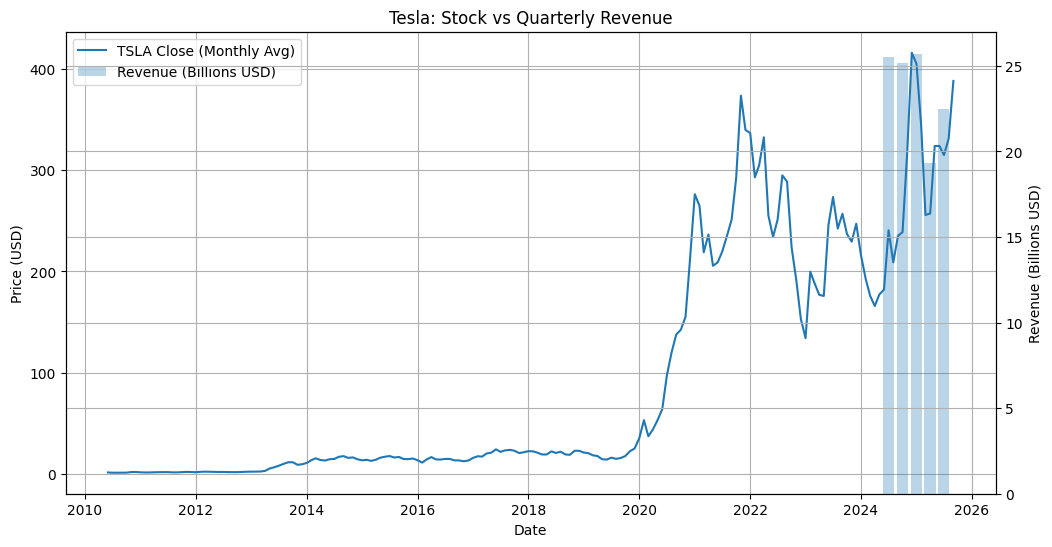

In [10]:
tsla_monthly = tsla_hist.set_index("Date")["Close"].resample("MS").mean()
fig, ax1 = plt.subplots()
ax1.plot(tsla_monthly.index, tsla_monthly.values, label="TSLA Close (Monthly Avg)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)")
ax1.set_title("Tesla: Stock vs Quarterly Revenue")
ax2 = ax1.twinx()
ax2.bar(tsla_revenue["Date"], tsla_revenue["Revenue_Billions"], alpha=0.3, width=75, align="center", label="Revenue (Billions USD)")
ax2.set_ylabel("Revenue (Billions USD)")
lines, labels = ax1.get_legend_handles_labels()
bars, blabels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + blabels, loc="upper left")
plt.show()

# Question 6 - GameStop Stock and Revenue Dashboard

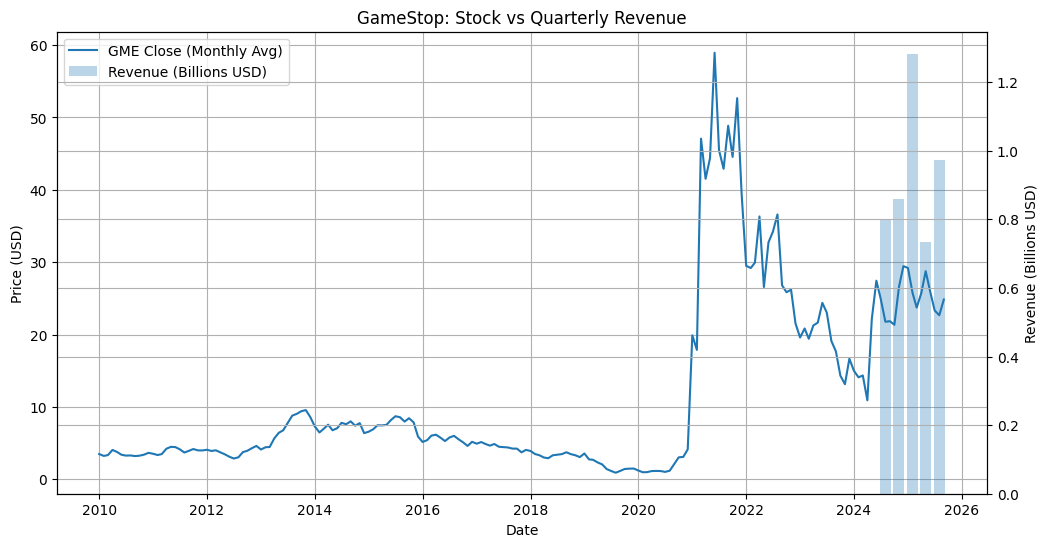

In [12]:
gme_monthly = gme_hist.set_index("Date")["Close"].resample("MS").mean()
fig, ax1 = plt.subplots()
ax1.plot(gme_monthly.index, gme_monthly.values, label="GME Close (Monthly Avg)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)")
ax1.set_title("GameStop: Stock vs Quarterly Revenue")
ax2 = ax1.twinx()
ax2.bar(gme_revenue["Date"], gme_revenue["Revenue_Billions"], alpha=0.3, width=75, align="center", label="Revenue (Billions USD)")
ax2.set_ylabel("Revenue (Billions USD)")
lines, labels = ax1.get_legend_handles_labels()
bars, blabels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + blabels, loc="upper left")
plt.show()